In [1]:
from util import *
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def AUE(list1,list2):
    return np.average(np.absolute(list1-list2))

In [30]:
sub_set = ['RG18', 'ADIM6', 'S22', 'S66', 'HEAVY28', 'WATER27', 'CARBHB12', 'PNICO23', 'HAL59', 'AHB21', 'CHB6', 'IL16',
           'IDISP', 'ICONF', 'ACONF', 'Amino20x4', 'PCONF21', 'MCONF', 'SCONF', 'UPU23', 'BUT14DIOL']

sub_set = [ 'ADIM6', 'S22', 'S66', 'WATER27', 'CARBHB12', 'AHB21', 'IL16',
        'ICONF', 'ACONF', 'Amino20x4', 'PCONF21', 'MCONF', 'SCONF', 'UPU23', 'BUT14DIOL']

#IDISP big xyz dimension

levels = ["01_B973c",
          "06_BLYP"
          ]
level_cp2k = ["01_DZVP-MOLOPT-SR"]

In [24]:
base_local = Path("../non-Co")
base = base_local


In [25]:
set_dict = {}
for s in sub_set:
    char_mul = base / ("CHARGE_MULTIPLICITY_%s.txt" % s)
    set_folder = base / s
    B_set = BenchmarkSet(file_name=char_mul, set_name=s)
    B_set.set_ref('Ref/'+ s + "ref.txt")
    for s_name in B_set.get_struct_names():
        for level in levels:
            B_set[s_name].set_Elevel_ORCA(level, set_folder / s_name / (level + ".out"))
        for level in level_cp2k:
            B_set[s_name].set_Elevel_CP2K(level, set_folder / s_name / (level + ".out"))
    for level in levels:
        B_set.calc_benchmark_data(level)
    for level in level_cp2k:
        B_set.calc_benchmark_data(level)

    set_dict[s] = B_set

In [31]:
levels = levels + level_cp2k
levels

['01_B973c', '06_BLYP', '01_DZVP-MOLOPT-SR']

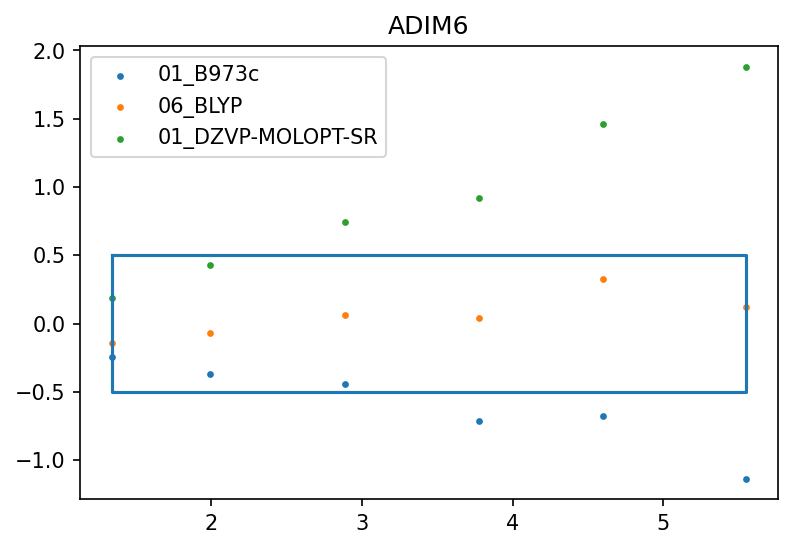

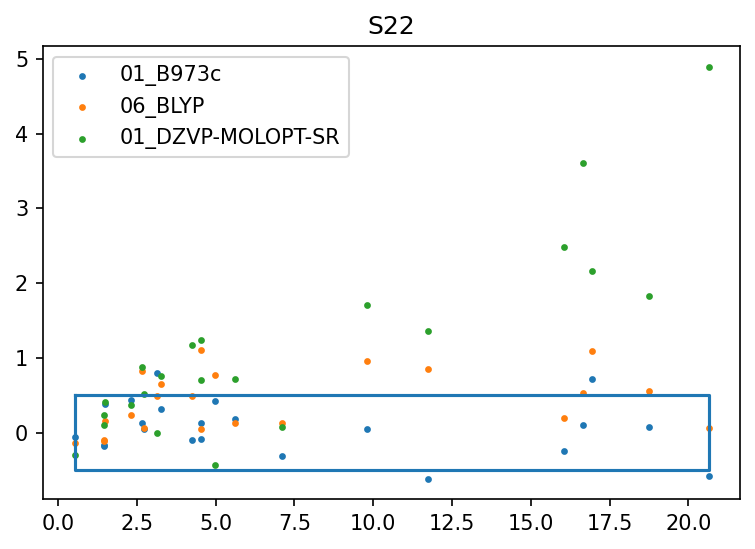

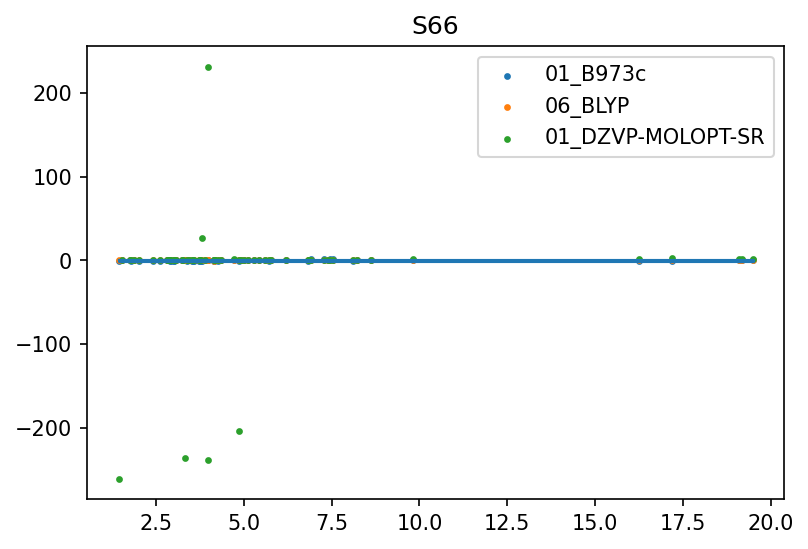

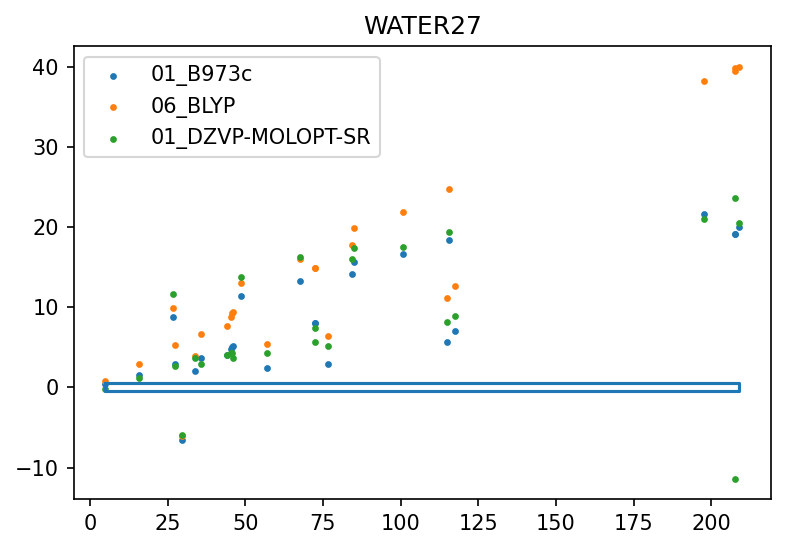

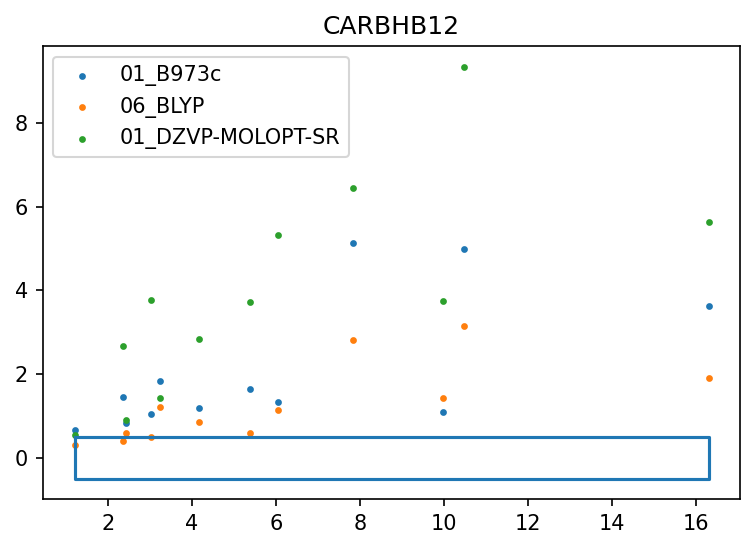

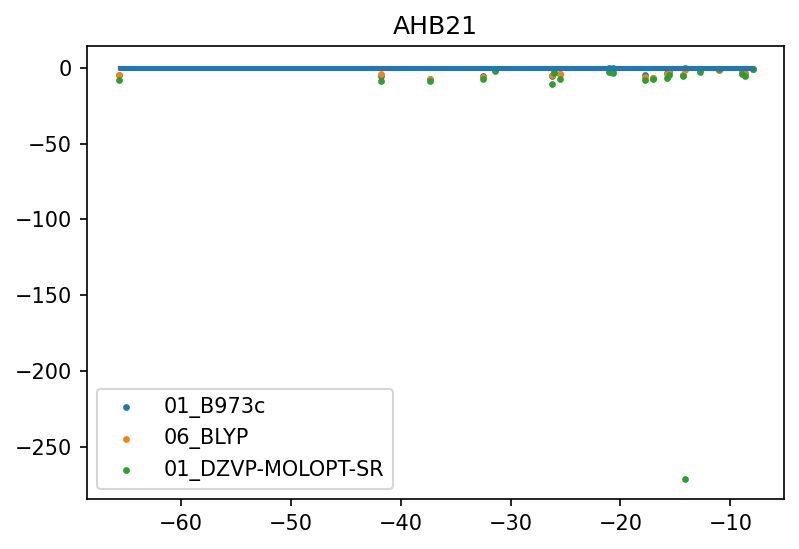

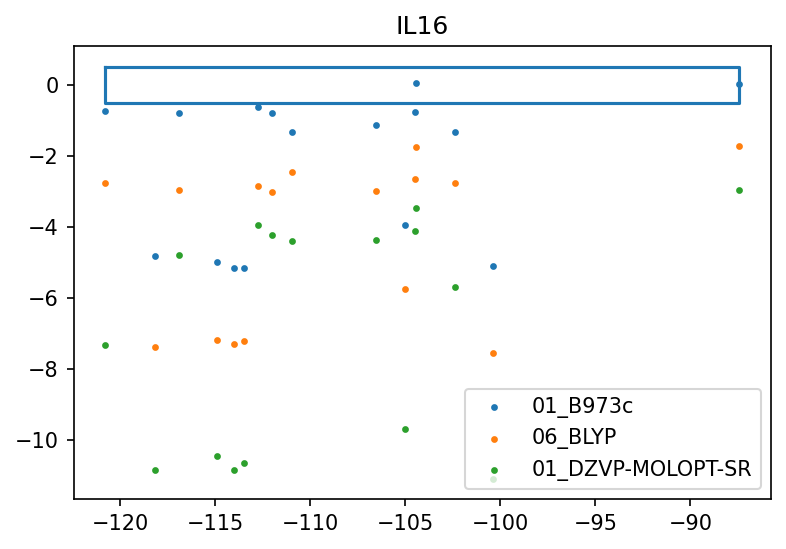

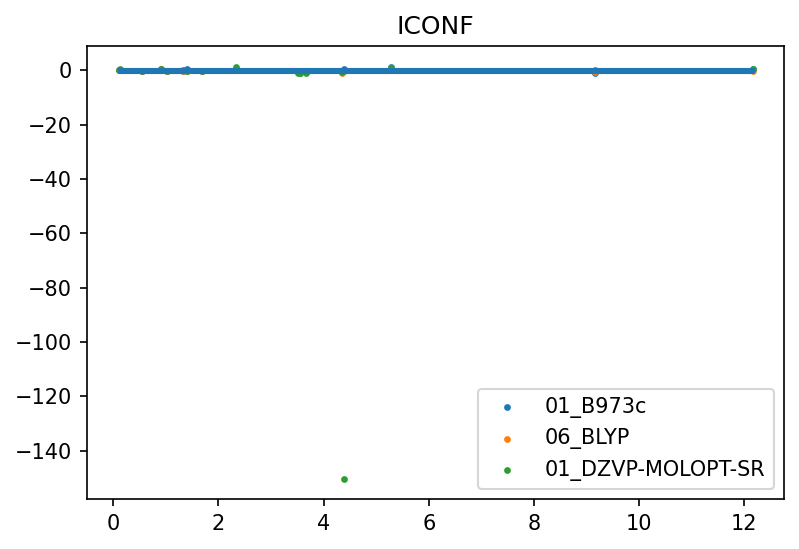

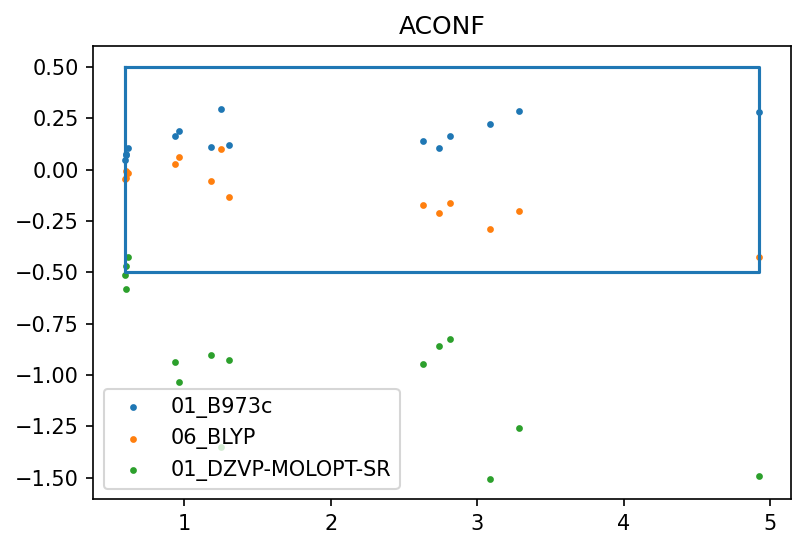

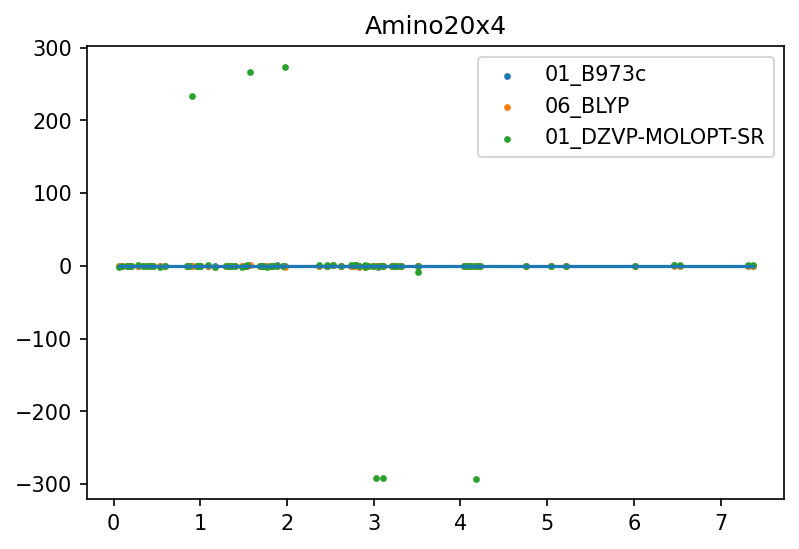

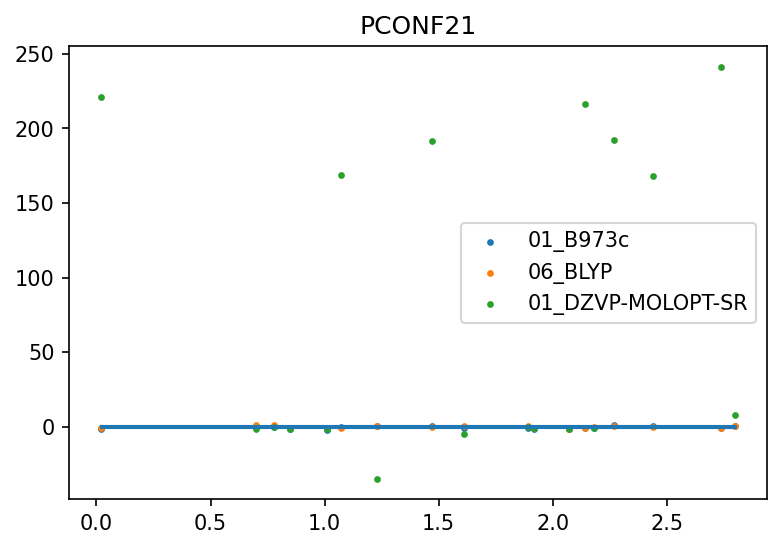

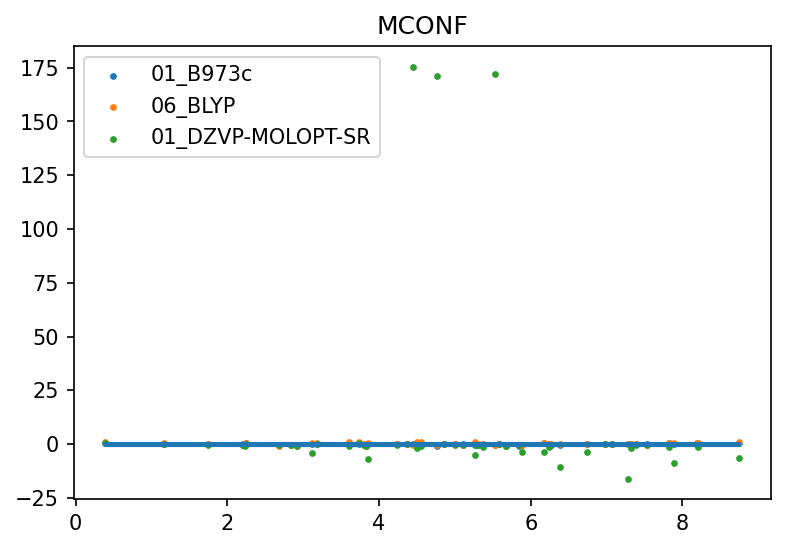

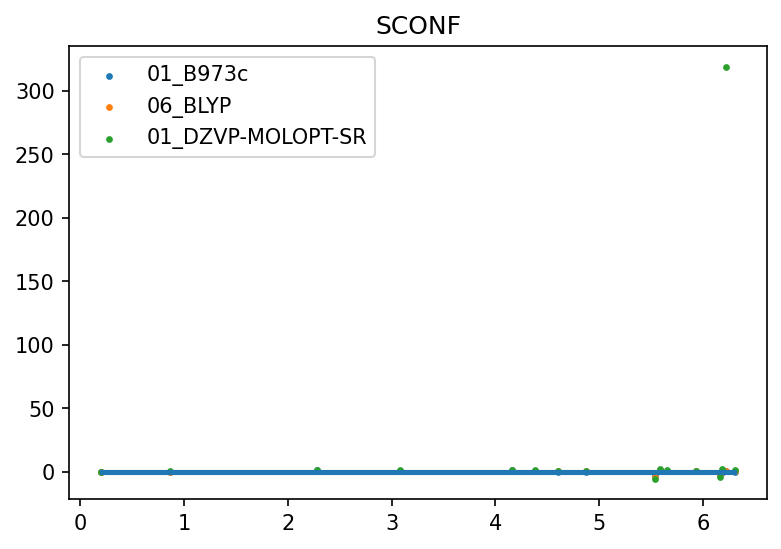

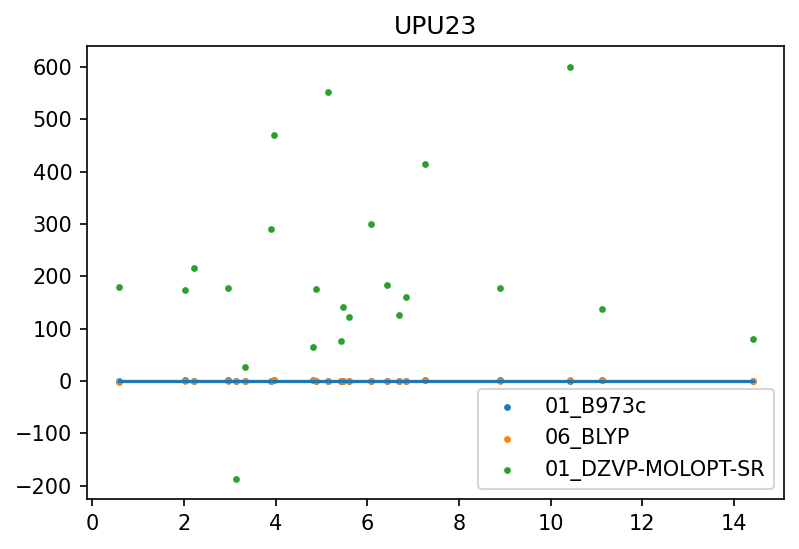

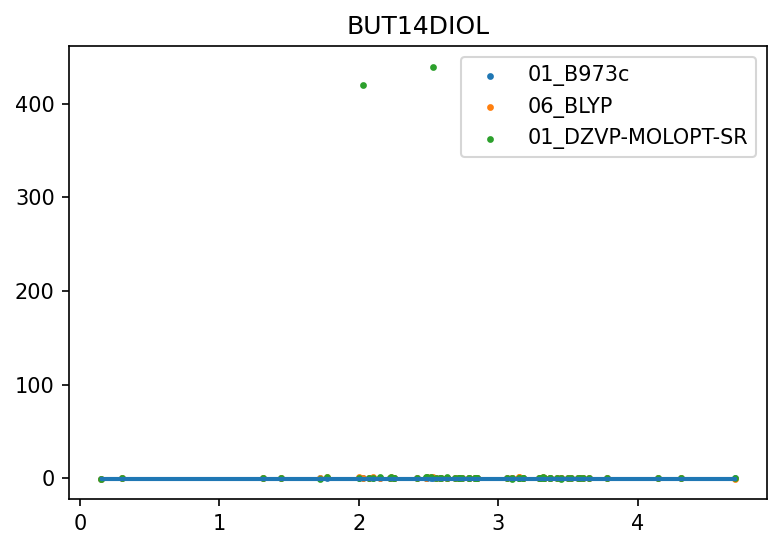

In [29]:
for s in sub_set:
    B_set = set_dict[s]
    plt.figure(s,dpi=150)
    for level in levels:
        bench_data = B_set.get_benchmark_data(level)
        bench_data = np.array(bench_data)
        _1, _2, _3, ref = B_set.get_ref()
        ref = np.array(ref)
        plt.scatter(ref, bench_data-ref,label=level,s=5)
    #draw a box from -0.5 to +0.5 kcal/mol
    plt.plot([ref.min(),ref.max(),ref.max(),ref.min(),ref.min()],[0.5,0.5,-0.5,-0.5,0.5])
    
    plt.title(s)
    plt.legend()
    plt.show()

In [32]:
AUE_dict = {"N":[],
            "delta_E":[],
            "01_B973c":[],
            "06_BLYP":[],
            "01_DZVP-MOLOPT-SR":[],
            }
for s in sub_set:
    B_set = set_dict[s]
    AUE_dict["N"].append(B_set.get_ref_num())
    AUE_dict["delta_E"].append(np.average(np.absolute(B_set.get_ref()[-1])))
    for level in levels:
        bench_data = B_set.get_benchmark_data(level)
        bench_data = np.array(bench_data)
        _1, _2, _3, ref = B_set.get_ref()
        ref = np.array(ref)
        
        AUE_dict[level].append(AUE(ref,bench_data))

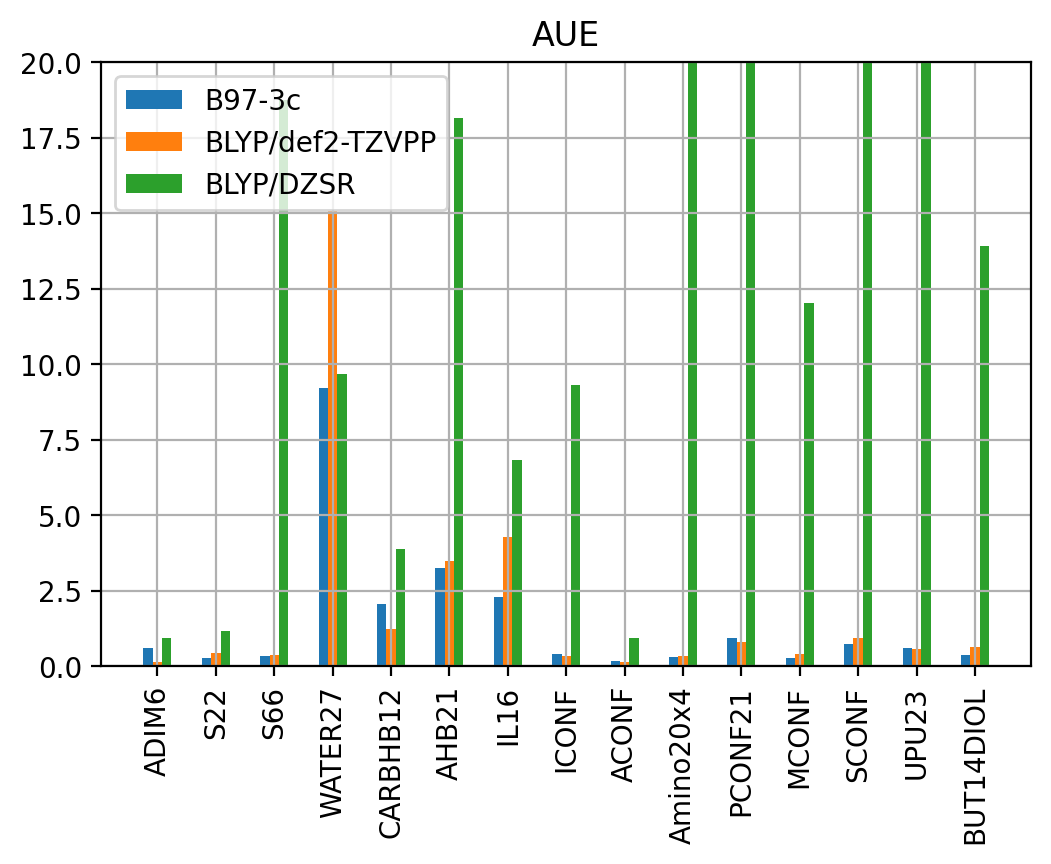

In [35]:
plt.figure("AUE",dpi=200)
plt.title("AUE")

x = np.arange(len(sub_set))
total_width, n = 0.8, 5
width = total_width / n



data = AUE_dict["01_B973c"]
plt.bar(x, data, width=width,label="B97-3c")
plt.xticks(rotation = 90)

data = AUE_dict["06_BLYP"]
plt.bar(x+width, data, width=width,label="BLYP/def2-TZVPP", tick_label=sub_set)

data = AUE_dict["01_DZVP-MOLOPT-SR"]
plt.bar(x+2*width, data, width=width,label="BLYP/DZSR")


plt.ylim(0,20)
plt.legend()
plt.grid()
#plt.yscale("log")
plt.savefig("AUE_CP2K.png")

In [15]:
AUE_dict["06_BLYP"]

[0.10929258366197853,
 0.12787276849208876,
 0.4415327669027808,
 0.38286507184046603,
 0.5100427413441606,
 15.06591060939362,
 1.2418185523868015,
 0.9690875089145645,
 1.1494386999316266,
 3.4803639620204643,
 1.586854595756984,
 4.273930051600546,
 4.9068041320923825,
 0.35206626786477174,
 0.13018023799657824,
 0.33693271540006975,
 0.7849727297367322,
 0.41153893326326985,
 0.9382171429011642,
 0.5794233222350316,
 0.6325420800826032]

In [16]:
bench_data = set_dict["RG18"].get_benchmark_data("06_BLYP")
ref        = set_dict["RG18"].get_ref()[-1]

In [17]:
for i,j in zip(ref,bench_data):
    print(i,j)

0.08 0.09922593313967809
0.27 0.2464294801466167
0.4 0.3489032778888941
0.27 0.30420645626145415
0.77 0.7447528783231974
1.18 1.1109295384958386
0.54 0.590171781484969
1.51 1.4460791538003832
1.13 1.2392515407991596
0.23 0.5317233199821203
0.59 0.9459049290962867
0.72 1.0733218462773948
0.12 0.14659712307911832
0.33 0.3098338909621816
0.24 0.4077841249309131
0.54 0.6251504808533355
0.4 0.5014172444061842
1.12 1.2294399452221114


In [90]:
for i in AUE_dict:
    AUE_dict[i] = np.array(AUE_dict[i])

In [91]:
def WTMAD2_GMTKN(AUE_dict,level):
    return 1/np.sum(AUE_dict['N'])*np.sum(AUE_dict['N']*56.84/AUE_dict['delta_E']*AUE_dict[level])


In [92]:
levels

['01_B973c', '02_BLYP', '03_B3LYP', '05_BLYP_orca4', '06_BLYP']

In [93]:
WTMAD2_GMTKN(AUE_dict,'01_B973c')

10.507663955307025

In [94]:
WTMAD2_GMTKN(AUE_dict,'02_BLYP')

42.655612734855985

In [95]:
WTMAD2_GMTKN(AUE_dict,'03_B3LYP')

41.01869573688188

In [96]:
WTMAD2_GMTKN(AUE_dict,'05_BLYP_orca4')

42.65748532791455

In [98]:
WTMAD2_GMTKN(AUE_dict,'06_BLYP')

9.742665191771719